# Predicting stock performance using Random Forests
Michael Vandervelden, July 2023 <br>
Project inspired by, and some code adapted from project by Lucas Rea found at
https://towardsdatascience.com/predicting-future-stock-market-trends-with-python-machine-learning-2bf3f1633b3c

In [54]:
# Import necessary libraries. Stock indicators and features are derived from the finta library.

import yfinance as yf
import datetime
import pandas as pd
import numpy as np
from finta import TA
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, LeaveOneOut
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

Create list of indicator names. These will be used later to get features for each respective ETF

In [5]:
INDICATORS = ['RSI', 'MACD', 'STOCH','ADL', 'ATR', 'MOM', 'MFI', 'ROC', 'OBV', 'CCI', 'EMV', 'VORTEX']

In [6]:
path = os.getcwd()
path = path + "\\ETFs"
csvs = glob.glob(os.path.join(path, "*.csv"))

Get list of the filepaths for 10 ETF's. Only one will be selected for deeper analysis and prediction.

In [7]:
csvs

['C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\ARKF.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\BITQ.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\BLOK.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\EMFQ.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\FINX.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\FNTC.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\IPAY.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\IYG.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\KOIN.csv',
 'C:\\Users\\brand\\OneDrive\\Documents\\Notebooks\\ETFs\\TPAY.csv']

Build iterable list of each ETF's name, and read in that stock's data using pandas.

In [8]:
list_of_names = ['arkf', 'bitq', 'blok', 'emfq', 'finx', 'fntc', 'ipay','iyg','koin','tpay']
df_list = []

num_dfs = len(list_of_names)

for i in range(num_dfs):
    temp_df = pd.read_csv(csvs[i])
    temp_df['name'] = list_of_names[i]
    df_list.append(temp_df)

In [9]:
df_list[9]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,name
0,2019-01-31 00:00:00-05:00,27.173500,27.173500,27.173500,27.173500,0,0,0,tpay
1,2019-02-01 00:00:00-05:00,27.173500,27.173500,27.173500,27.173500,0,0,0,tpay
2,2019-02-04 00:00:00-05:00,27.173500,27.173500,27.173500,27.173500,0,0,0,tpay
3,2019-02-05 00:00:00-05:00,27.173500,27.173500,27.173500,27.173500,0,0,0,tpay
4,2019-02-06 00:00:00-05:00,27.173500,27.173500,27.173500,27.173500,0,0,0,tpay
...,...,...,...,...,...,...,...,...,...
935,2022-10-17 00:00:00-04:00,24.635000,24.635000,24.635000,24.635000,12,0,0,tpay
936,2022-10-18 00:00:00-04:00,25.129999,25.129999,24.719999,24.895000,2546,0,0,tpay
937,2022-10-19 00:00:00-04:00,24.590000,24.590000,24.364799,24.364799,101,0,0,tpay
938,2022-10-20 00:00:00-04:00,24.799999,24.799999,24.303600,24.303600,212,0,0,tpay


In [10]:
fntc.head()

NameError: name 'fntc' is not defined

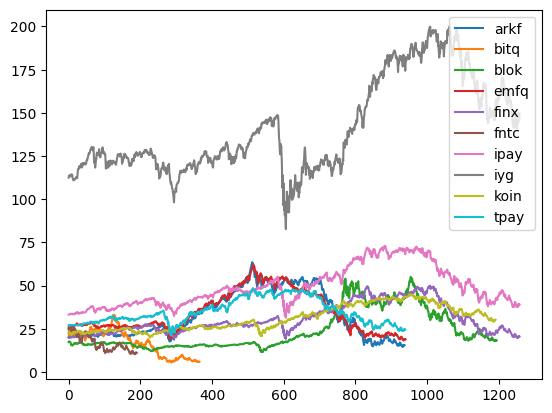

In [11]:
plt.figure()
for df in df_list:
    plt.plot(df['Close'], label=df['name'][0])
    plt.legend()

Above is a time series plot of each ETF's close price. Given BLOK's significant increase in value, subsequent volatility, and slow decline, this the ETF we will select for our predictive analysis.

In [12]:
blok_prelim = df_list[2]

In [13]:
blok_prelim.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,name
0,2018-01-25 00:00:00-05:00,17.668915,17.702252,17.402213,17.418882,1140200,0.0,0,blok
1,2018-01-26 00:00:00-05:00,17.485556,17.643909,17.460553,17.643909,1067100,0.0,0,blok
2,2018-01-29 00:00:00-05:00,17.760592,17.884774,17.693916,17.760592,1133900,0.0,0,blok
3,2018-01-30 00:00:00-05:00,17.693918,17.693918,17.418883,17.468889,1096700,0.0,0,blok
4,2018-01-31 00:00:00-05:00,17.493892,17.526395,17.293866,17.410547,706100,0.0,0,blok


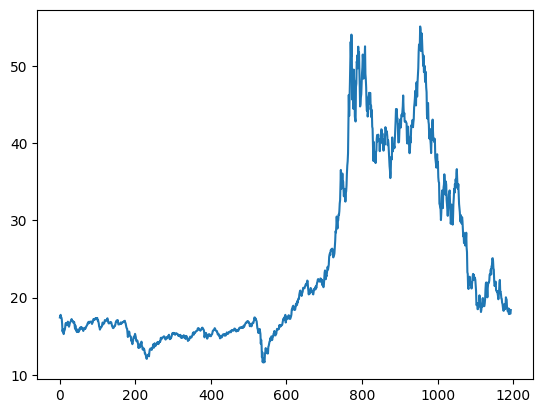

In [14]:
plt.plot(blok_prelim['Close'])

Another plot of BLOK's close price.

In [15]:
blok_prelim.rename(columns={'Date': 'date','Close':'close', 'Open':'open', 'High':'high', 'Low':'low', 'Volume':'volume'}, inplace=True)

In [16]:
blok_prelim.head()

,date,open,high,low,close,volume,Dividends,Stock Splits,name
0,2018-01-25 00:00:00-05:00,17.668915,17.702252,17.402213,17.418882,1140200,0.0,0,blok
1,2018-01-26 00:00:00-05:00,17.485556,17.643909,17.460553,17.643909,1067100,0.0,0,blok
2,2018-01-29 00:00:00-05:00,17.760592,17.884774,17.693916,17.760592,1133900,0.0,0,blok
3,2018-01-30 00:00:00-05:00,17.693918,17.693918,17.418883,17.468889,1096700,0.0,0,blok
4,2018-01-31 00:00:00-05:00,17.493892,17.526395,17.293866,17.410547,706100,0.0,0,blok


In [17]:
blok_prelim.drop(columns=['name'], inplace=True)

In [18]:
def get_indicators(data):
    
    for i in INDICATORS:
        
        ind_data = eval('TA.' + i + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
            
        data = data.merge(ind_data, left_index=True, right_index=True)
        
    data.rename(columns={"14 period EMV.": '14 period EMV'}, inplace=True)

    # calculate moving averages for features
    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema21'] = data['close'] / data['close'].ewm(21).mean()
    data['ema15'] = data['close'] / data['close'].ewm(14).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    # instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    
    return data

Function for assigning stock features, including the 50-day, 21-day, 15-day, and 5-day moving averages.

In [19]:
blok = get_indicators(blok_prelim)

In [20]:
blok

,date,open,high,low,close,volume,Dividends,Stock Splits,14 period RSI,MACD,...,OBV,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol
0,2018-01-25 00:00:00-05:00,17.668915,17.702252,17.402213,17.418882,1140200,0.0,0,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1,2018-01-26 00:00:00-05:00,17.485556,17.643909,17.460553,17.643909,1067100,0.0,0,100.000000,0.005049,...,1067100.0,66.666667,NaN,NaN,NaN,1.006354,1.006268,1.006195,1.005831,0.969802
2,2018-01-29 00:00:00-05:00,17.760592,17.884774,17.693916,17.760592,1133900,0.0,0,100.000000,0.010051,...,2201000.0,100.000000,NaN,NaN,NaN,1.008549,1.008375,1.008230,1.007507,1.018221
3,2018-01-30 00:00:00-05:00,17.693918,17.693918,17.418883,17.468889,1096700,0.0,0,50.898350,0.001548,...,1104300.0,-53.342890,NaN,NaN,NaN,0.994036,0.993992,0.993959,0.993852,0.989653
4,2018-01-31 00:00:00-05:00,17.493892,17.526395,17.293866,17.410547,706100,0.0,0,46.030189,-0.005426,...,398200.0,-105.322915,NaN,NaN,NaN,0.992633,0.992700,0.992763,0.993153,0.708843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1190,2022-10-17 00:00:00-04:00,18.410000,18.700001,18.410000,18.490000,215300,0.0,0,43.175095,-0.564751,...,-9344400.0,-41.534425,-0.108636,0.923517,0.894925,0.847673,0.934245,0.956184,0.992906,1.017894
1191,2022-10-18 00:00:00-04:00,18.879999,18.950001,18.209999,18.340000,122800,0.0,0,42.061720,-0.548512,...,-9467200.0,-41.900837,-0.161270,0.917862,0.862267,0.843429,0.929765,0.951699,0.987344,0.624208
1192,2022-10-19 00:00:00-04:00,18.129999,18.312000,17.840000,17.980000,268200,0.0,0,39.433446,-0.558256,...,-9735400.0,-107.438868,-0.192471,0.967225,0.857485,0.829690,0.915196,0.937203,0.973159,1.285461
1193,2022-10-20 00:00:00-04:00,17.980000,18.469999,17.850000,17.900000,207600,0.0,0,38.852450,-0.565910,...,-9943000.0,-94.020281,-0.250216,0.985373,0.844659,0.828826,0.914819,0.937217,0.973889,0.995839


A quick look at our data.

In [21]:
def assign_truth_values(data, timeframe):
    
    prediction = (data.shift(-timeframe)['close'] >= data['close'])
    prediction = prediction.iloc[:-timeframe]
    
    data['pred'] = prediction.astype(int)
    
    return data

Function to assign binary truth values to each day in the time series. An assignment of 1.0 denotes a day on which the stock should be purchased, predicting good performance in the near future. 

In [22]:
blok_truth_values = assign_truth_values(blok, timeframe=14)
blok_truth_values.drop(columns=['close'], inplace=True)
blok_truth_values.dropna(inplace=True)
blok_truth_values.tail()

,date,open,high,low,volume,Dividends,Stock Splits,14 period RSI,MACD,SIGNAL,...,20 period CCI,14 period EMV,VIm,VIp,ema50,ema21,ema15,ema5,normVol,pred
1176,2022-09-27 00:00:00-04:00,18.75,18.980000,18.230000,177700,0.0,0,32.021852,-0.855965,-0.646632,...,-125.655575,-0.208787,1.023099,0.833904,0.808095,0.887088,0.904547,0.954139,0.807674,1.0
1177,2022-09-28 00:00:00-04:00,18.40,19.170000,18.389999,153800,0.0,0,40.191677,-0.813553,-0.680017,...,-87.894002,-0.243388,1.073796,0.817061,0.841914,0.924607,0.943241,0.992436,0.735960,0.0
1178,2022-09-29 00:00:00-04:00,18.74,18.794001,18.330000,224700,0.0,0,36.529215,-0.814929,-0.706999,...,-101.819036,-0.382241,1.130613,0.672394,0.820629,0.902192,0.921260,0.969724,1.061914,0.0
1179,2022-09-30 00:00:00-04:00,18.48,19.150000,18.469999,159200,0.0,0,36.078602,-0.812303,-0.728060,...,-81.287045,-0.358474,1.129750,0.649645,0.820471,0.902946,0.922845,0.971563,0.784755,0.0
1180,2022-10-03 00:00:00-04:00,18.66,19.090000,18.450001,164900,0.0,0,41.313271,-0.763496,-0.735147,...,-65.035604,-0.250317,1.145854,0.727945,0.843941,0.929015,0.949691,0.996870,0.839023,0.0


## Generating training and testing data, building our Random Forest models
We will be splitting our data into training and testing data. 80% of the data will be used to train our model, while the remaining 20% will be used to test its predictive accuracy, shown by passing in 0.20 as the 'test_size' argument when splitting the data.

In [23]:
blok_truth_values.drop(columns=["date"], inplace=True)

In [24]:
X = blok_truth_values.drop(columns=["pred"], axis=1)

In [25]:
y = blok_truth_values['pred']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=22)

In [27]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

RandomForestClassifier()

Initial testing of the basic first model yields high test accuracy (obviously a positive indicator), but also a training accuracy of 1.0. This indicates that our model is possibly overfitting. We will remedy this by tuning the hyperparameters of the Random Forest model, to build the optimal model. 

In [28]:
random_forest.score(X_test, y_test)

0.8658008658008658

In [29]:
random_forest.score(X_train, y_train)

1.0

Using Halving Grid Search from the sklearn library, we will search an array of potential permutations of specific hyperparameters, defined by 'parameter_grid' below. The hyperparameters will adjust include the maximum depth of each tree in the forest, the minimum samples required to split a tree node, and the minimum samples required to be at a leaf node in a tree. The resource we will use is the number of trees in the forest ('n_estimators').

In [30]:
parameter_grid = {'max_depth': [3,5,10],
                 'min_samples_split': [2,5,10],
                 'min_samples_leaf':[1,3,5,10]}

base_estimator = RandomForestClassifier(random_state=0)

halving = HalvingGridSearchCV(base_estimator, parameter_grid, cv=5,
                             factor=2, resource='n_estimators',
                             max_resources=30).fit(X, y)

After running Halving Grid Search on the parameter grid, the optimal model is detailed below.

In [31]:
halving.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=16,
                       random_state=0)

In [32]:
model = RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=16,
                              random_state=0)

In [33]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=16,
                       random_state=0)

After fitting our newly tuned model, the test accuracy is a more realistic 82%, with a training accuracy of 97%. This is good evidence that our model is no longer overfitting. 

In [34]:
model.score(X_test, y_test)

0.8181818181818182

In [35]:
model.score(X_train, y_train)

0.9707158351409978

# Determining the most useful features
Below, the feature importances for each respective feature in our data are displayed in a dataframe. Each importance value is that feature's percentage of the data's ability to predict a favourable close price. The open, high and low prices are expectedly useful, but the metrics of Modified Fixed Variable (MFV) rate and On Balance Volume (OBV) interestingly make up a larger share. 

In [36]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
feature_names = [f"{i}" for i in X.columns]

In [37]:
d = {"feature":X.columns, "importance":importances}
importances_df = pd.DataFrame(data=d)
importances_df

,feature,importance
0,open,0.072016
1,high,0.077766
2,low,0.060543
3,volume,0.026770
4,Dividends,0.000000
5,Stock Splits,0.000000
6,14 period RSI,0.038563
7,MACD,0.042175
8,SIGNAL,0.053150
9,14 period STOCH %K,0.016541


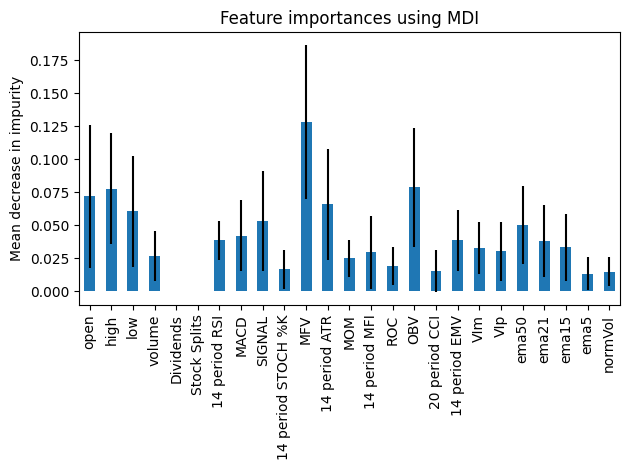

In [38]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Above is a visualization of each feature's importance based on mean decrease in impurity. 

Not only have we implemented an effective model for predicting a stock's performance, but we have quantified and visualized the importance of several key metrics for accomplishing this task. 

## Further evaluation of model performance 

In addition to simply measuring our model's predictive accuracy, we will be employing several different methods of quantifying the model's performance, including a confusion matrix, precision/recall, and an ROC curve. 

## Precision and Recall

Precision is a measure of a model's ability to identify more relevant results than irrelevant ones, while recall is a measure of a model's ability to identify most of the relevant results (regardless of how many irrelevant results are identified). 

Precision is defined by the following formula:

$\begin{equation}
precision = \frac {\text{relevant retrieved instances}}{\text{all retrieved instances}}
\end{equation}
$

Recall is defined by the following formula:

$\begin{equation}
recall = \frac {\text{relevant retrieved instances}}{\text{all relevant instances}}
\end{equation}
$

Let's explain these concepts with an example. In the context of predicting whether or not to purchase a stock, the model may select 100 days on which to purchase stock, 81 of which are selected correctly. The precision for this example is $ 81 / 100 $, or 0.81. If there are 90 days on which the stock should be purchased, and the model selects 81, then the recall for this example is $ 81 / 90 $, or 0.90. 

The precision and recall for our model is below:

In [71]:
y_pred  = model.predict(X)
print("Precision: ", metrics.precision_score(y, y_pred))
print("Recall: ", metrics.recall_score(y, y_pred))

Precision:  0.9389312977099237
Recall:  0.9549689440993789


Let's get an even better understanding of these metrics by plotting the precision-recall curve for our model.

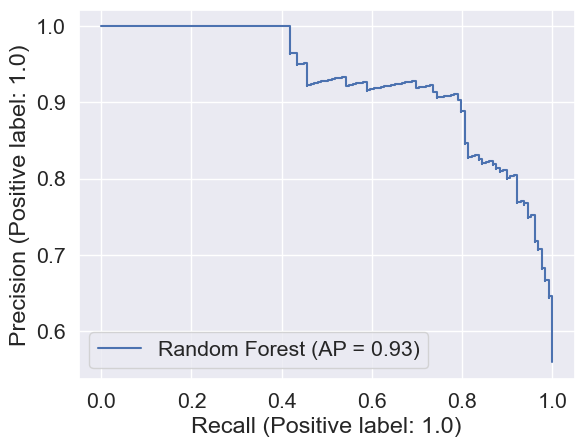

In [75]:
prec_rec_display = metrics.PrecisionRecallDisplay.from_estimator(
model, X_test, y_test, name="Random Forest")

The area under the curve is large, which is reflective of the model's high precision and high recall. 

## ROC Curve

An ROC (Receiver Operating Characteristic) curve plots the true positive rate against the false positive rate. The Area Under Curve (AUC) is another measure of predictive accuracy, being a measure of the model's ability to distinguish between classes (in our case, whether or not to buy a certain stock). 

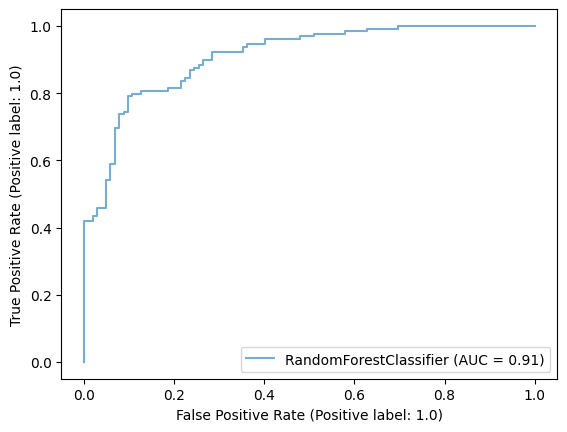

In [48]:
roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, alpha=0.6)

Our ROC curve increases dramatically towards the top left corner of the plot, indicating good performance. The area under the curve is 0.91, indicating the model's excellent ability to distinguish between classes. 

## Confusion Matrix
A confusion matrix is another way to summarize the predictions made by a model and their accuracy. Representing predictions this way gives us a glimpse into how well a model performs when predicting each different class label. 

In [66]:
# Generate predictions. The resulting array will be used to create the confusion matrix and corresponding plot. 

y_pred = model.predict(X_test)

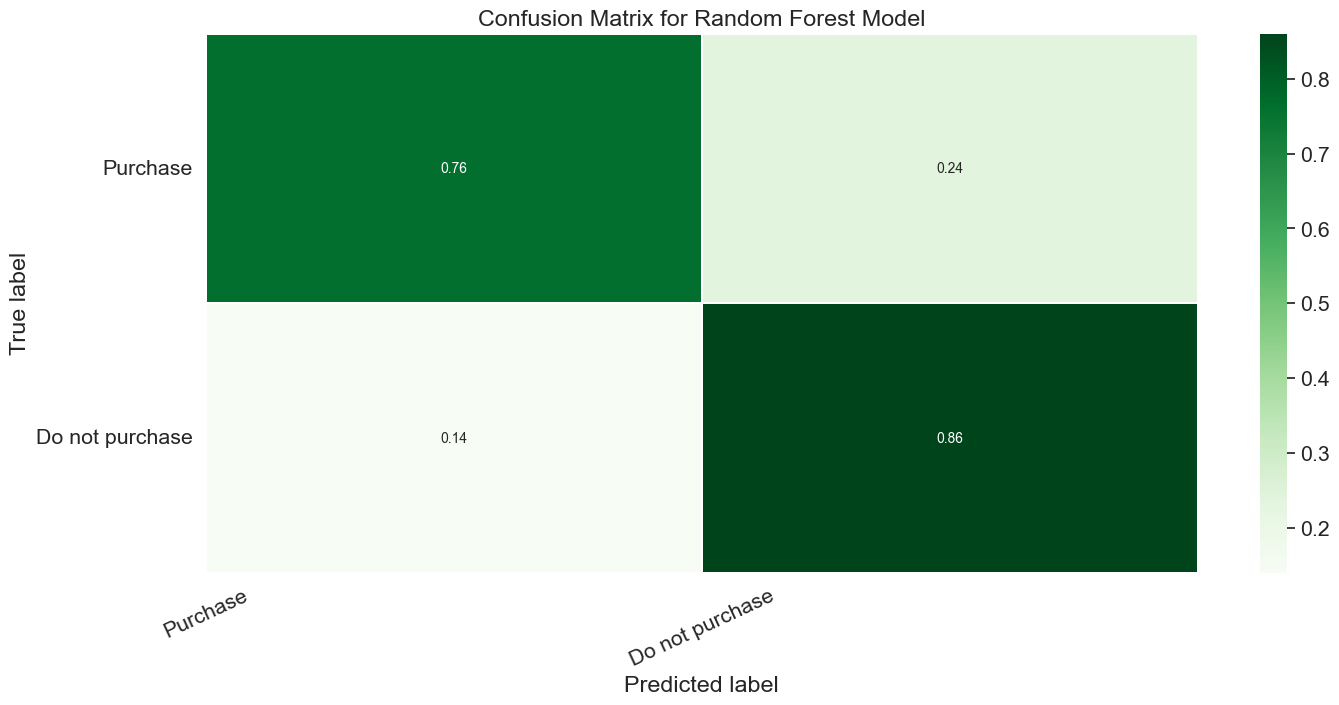

In [67]:
# Code adapted from example found at:
# https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ["Purchase", "Do not purchase"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

The confusion matrix for our model shows that the model predicts when not to buy the stock with slightly better accuracy than when to actually buy the stock. Regardless, the total performance is still very good.